In [1]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
# indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/mt_as_clones"
# se_meta = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"

# indir = "/data/Mito_Trace/output/pipeline/v02/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init"
# se_meta = "/data/Mito_Trace/output/pipeline/v02/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_hg38_1_2/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v02/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_init/anno_mt_af"

n_vars=30
#/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/mt_as_clones/mt_nuclear_af.ipynb /data/Mito_Trace/output/pipeline/v02/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_init/anno_mt_af/out.ipynb

indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion" 
se_meta = "/data/Mito_Trace/output/pipeline/v02/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/anno_mt_af"


In [3]:
#samples = samples.split(",")

### Smaller params

In [4]:
don_dirs = [d for d in glob(indir + "/donor*") if isdir(d)]
don_dirs = {int(x.split("donor")[-1]):x for x in don_dirs}
#don_dirs = {x:don_dirs[x] for x in don_dirs if x in range(n_donors)}
don_dirs

{0: '/data/Mito_Trace/output/pipeline/v02/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor0',
 1: '/data/Mito_Trace/output/pipeline/v02/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor1'}

In [5]:
# thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
# read_thresh = [2, 10, 25, 50, 100]
# thresholds = [0.1, 0.25]#
# read_thresh = [25, 50]

# thresholds = [t]
# read_thresh=[rt]
# cells_thresh=10
# ref_cells_thresh=500

In [6]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    return af, cov, cells_meta, variants



In [7]:
af_d = {}
for d in don_dirs: 
    curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    #curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)
    af_d[d] = curr_af
#     full_params_df = full_params.copy()
#     #curr_af_cov.apply(run_per_pos, args=(full_params_df,),expand=True)
#     all_passed_vars = defaultdict(list)
#     params_results = full_params_df.copy()
#     params_results["Variants"] = None


ic| cells_meta.shape: (2367, 6)
ic| 'After filtering on af indices', cells_meta.shape: (2367, 6)
ic| cells_meta.shape: (1730, 6)
ic| 'After filtering on af indices', cells_meta.shape: (1730, 6)


In [8]:
# append any unseen variants in different donors
allVars = [set(af_d[d].columns) for d in af_d]
allVars = allVars[0].union(*allVars)
len(allVars)

for d in af_d:
    unseen_cols = allVars - set(af_d[d].columns.values)
    print(len(unseen_cols))
    af_d[d].loc[:, unseen_cols] = 0

0
0


In [9]:
af_d[1].shape

(1730, 107)

In [10]:
af_d[0].shape

(2367, 107)

In [11]:
labels_df = pd.read_csv(se_meta,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

if "cluster_labels" in labels_df.columns:
    labels_df["labels"] = labels_df["cluster_labels"]
else:
    labels_df["labels"] = labels_df["seurat_clusters"]
   

(4657, 41)
(4062, 41)


## Group by labels and donor and get MT average

In [12]:
all_cells=[]
for d in af_d:
    all_cells.extend(af_d[d].index.values)
all_cells = set(all_cells) #set([af_d[d].index.values for d in af_d])

print(labels_df.shape)
labels_df = labels_df[labels_df.index.isin(all_cells)]
print(labels_df.shape)

(4062, 42)
(4062, 42)


In [13]:
def get_mt_mean(curr_df, af_d, labels_df):
    #print(af_d)
    #print(af_d[0])
    print(curr_df.name)
    lab, don = curr_df.name
    cells = labels_df[(labels_df["donor"]==don) & (labels_df["labels"]==lab)].index
    #print(lab, don)
    curr_af = af_d[int(don)]
    #print(curr_af.loc[cells].mean(axis=0).shape)
    return curr_af.loc[cells].mean(axis=0) #curr_af.loc[curr_af.index.isin(curr_df.index)].mean(axis=0)
 
lin_mt_af = pd.DataFrame(index=labels_df.groupby(["labels", "donor"]).size().index, columns=allVars).apply(get_mt_mean, axis=1,args=(af_d,labels_df))
lin_mt_af.head()

(0, '0')
0 0
(107,)
(0, '1')
0 1
(107,)
(1, '0')
1 0
(107,)
(1, '1')
1 1
(107,)
(2, '0')
2 0
(107,)
(2, '1')
2 1
(107,)
(3, '0')
3 0
(107,)
(3, '1')
3 1
(107,)
(4, '0')
4 0
(107,)
(4, '1')
4 1
(107,)
(5, '0')
5 0
(107,)
(5, '1')
5 1
(107,)
(6, '0')
6 0
(107,)
(6, '1')
6 1
(107,)
(7, '0')
7 0
(107,)
(7, '1')
7 1
(107,)
(8, '0')
8 0
(107,)
(8, '1')
8 1
(107,)
(9, '0')
9 0
(107,)
(9, '1')
9 1
(107,)


In [14]:
# lab = "monocyte"
# donor = "0"
# curr_df = labels_df.loc[(labels_df["labels"]==lab) & (labels_df["donor"]==donor)]
# #lab, don = curr_df.name
# print(lab, donor)
# curr_af = af_d[int(donor)]
# print(curr_af.loc[curr_af.index.isin(curr_df.index)].mean(axis=0))


# Sort variants by variance

In [15]:
from mplh.color_utils import create_color_df_v02

In [16]:
#curr_don_mt = don_lin_mt_af.set_index(["labels","donor"]).rename({"level_2":"variant"},axis=1)

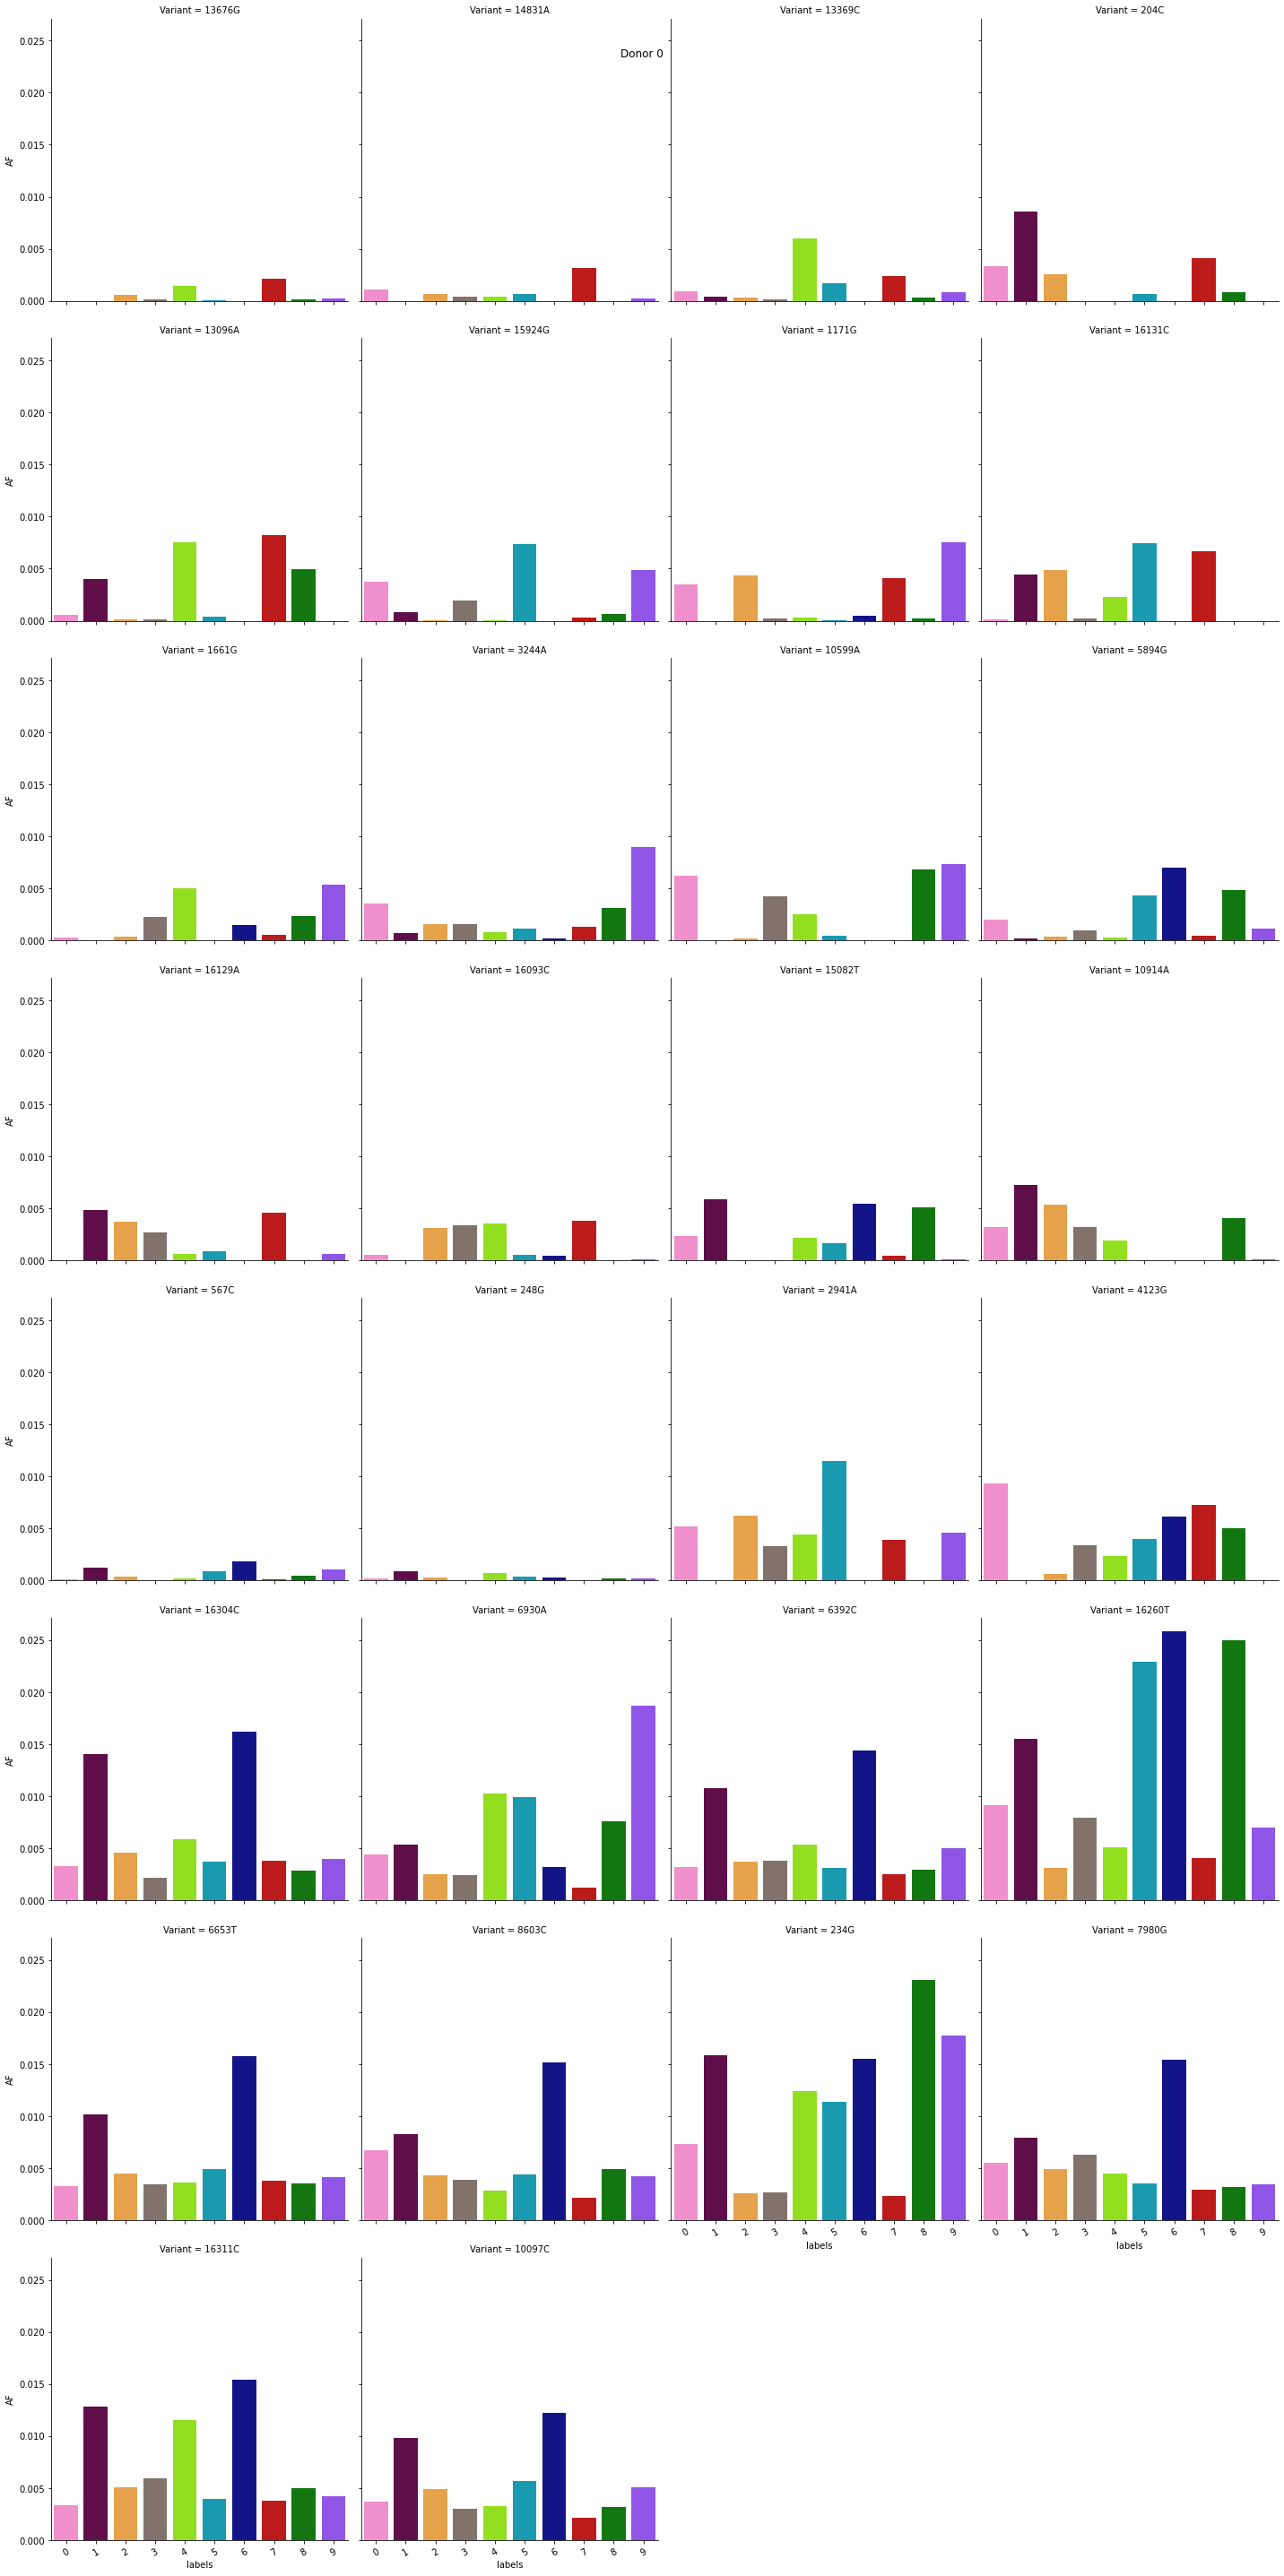

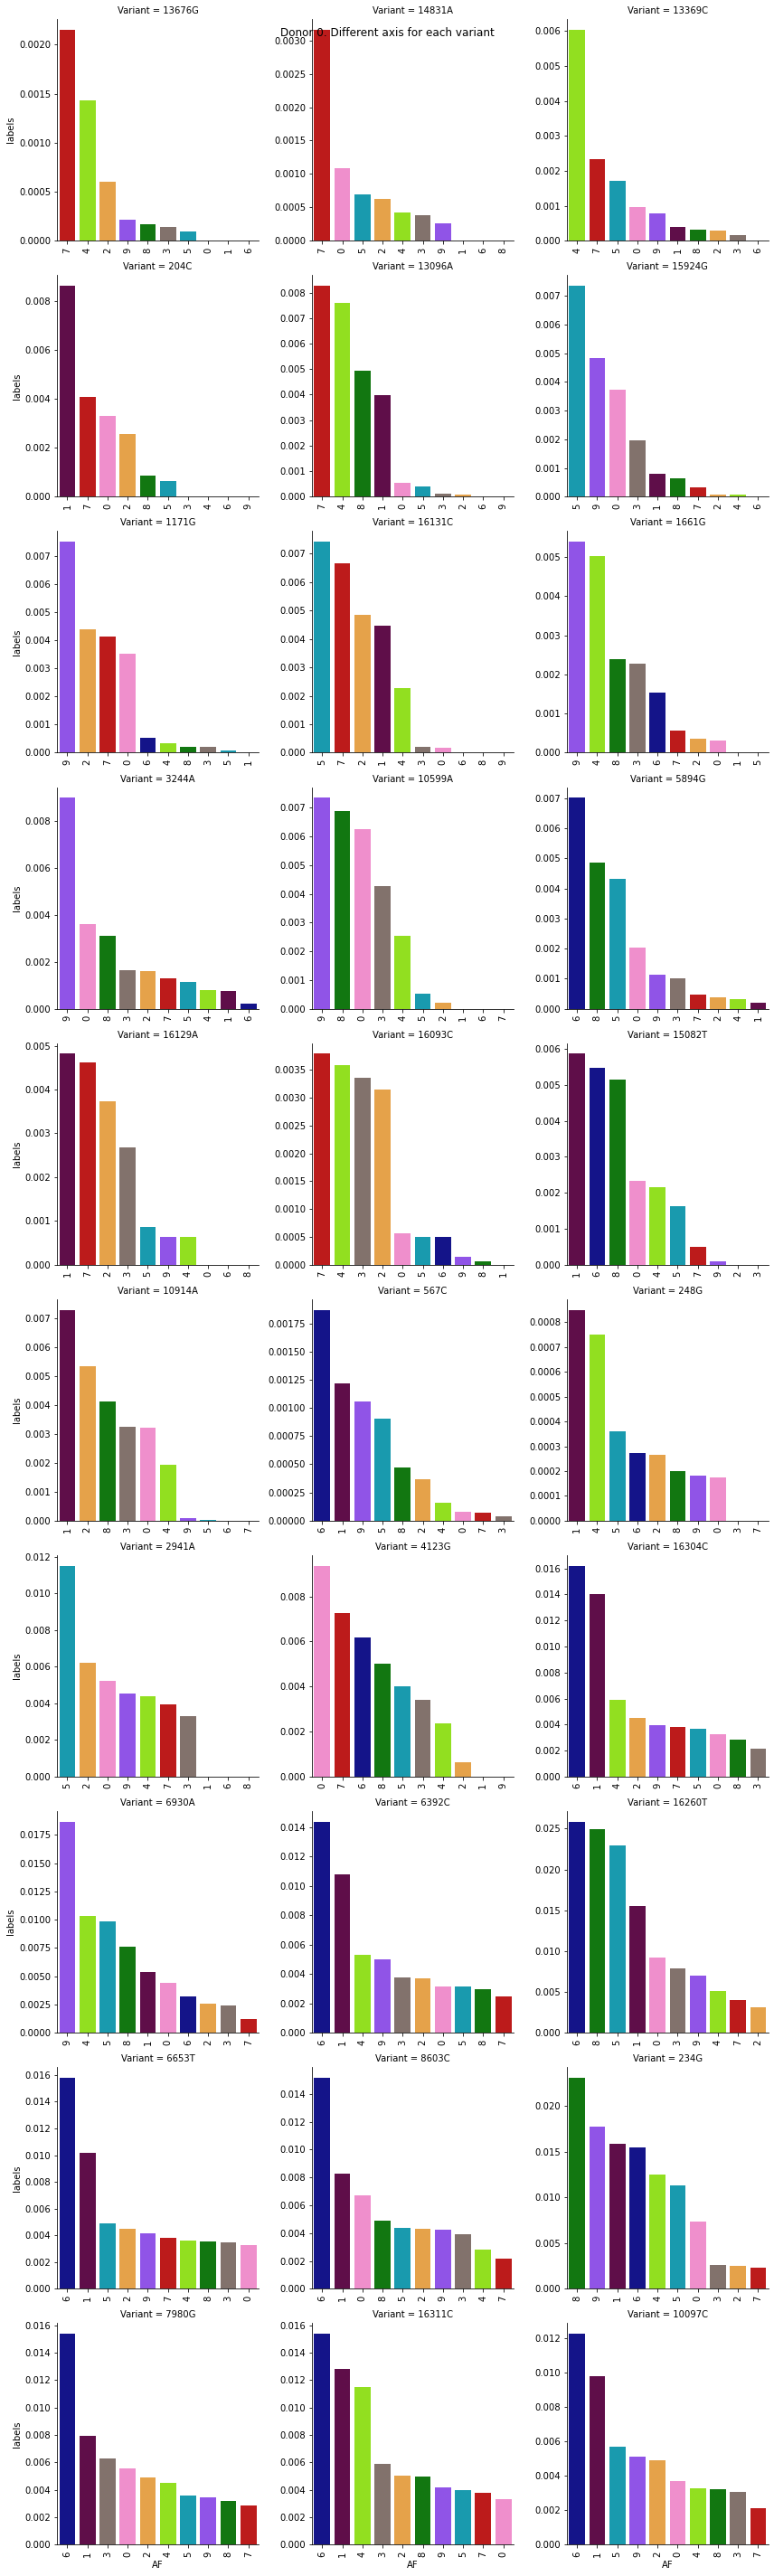

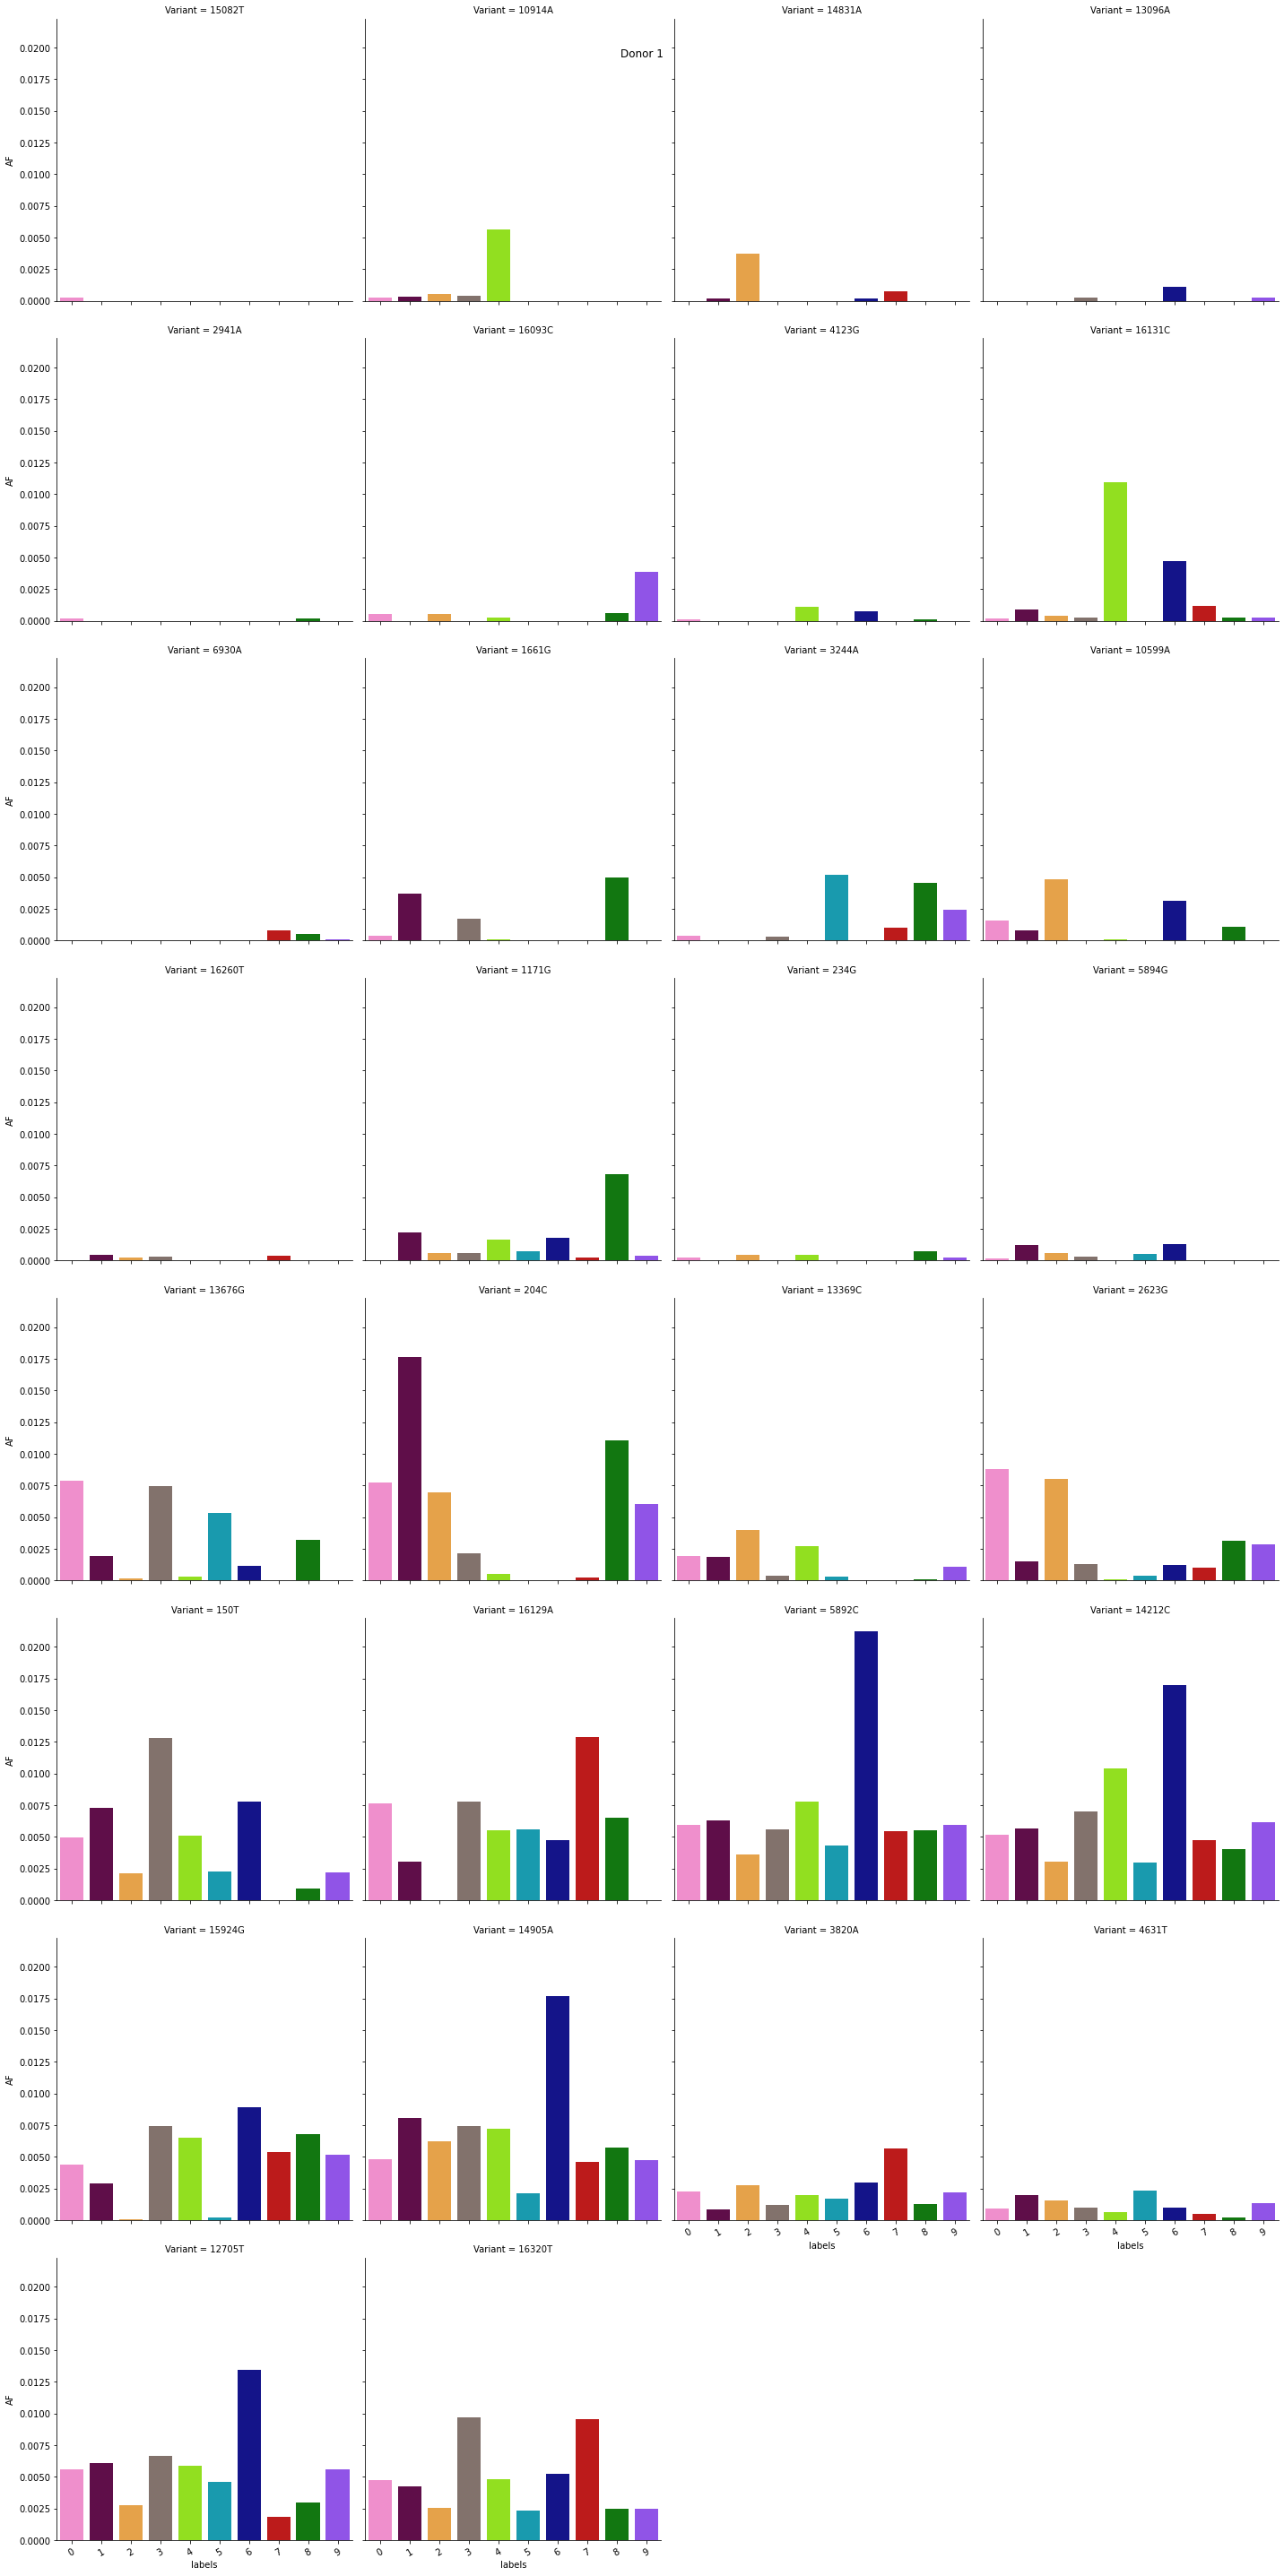

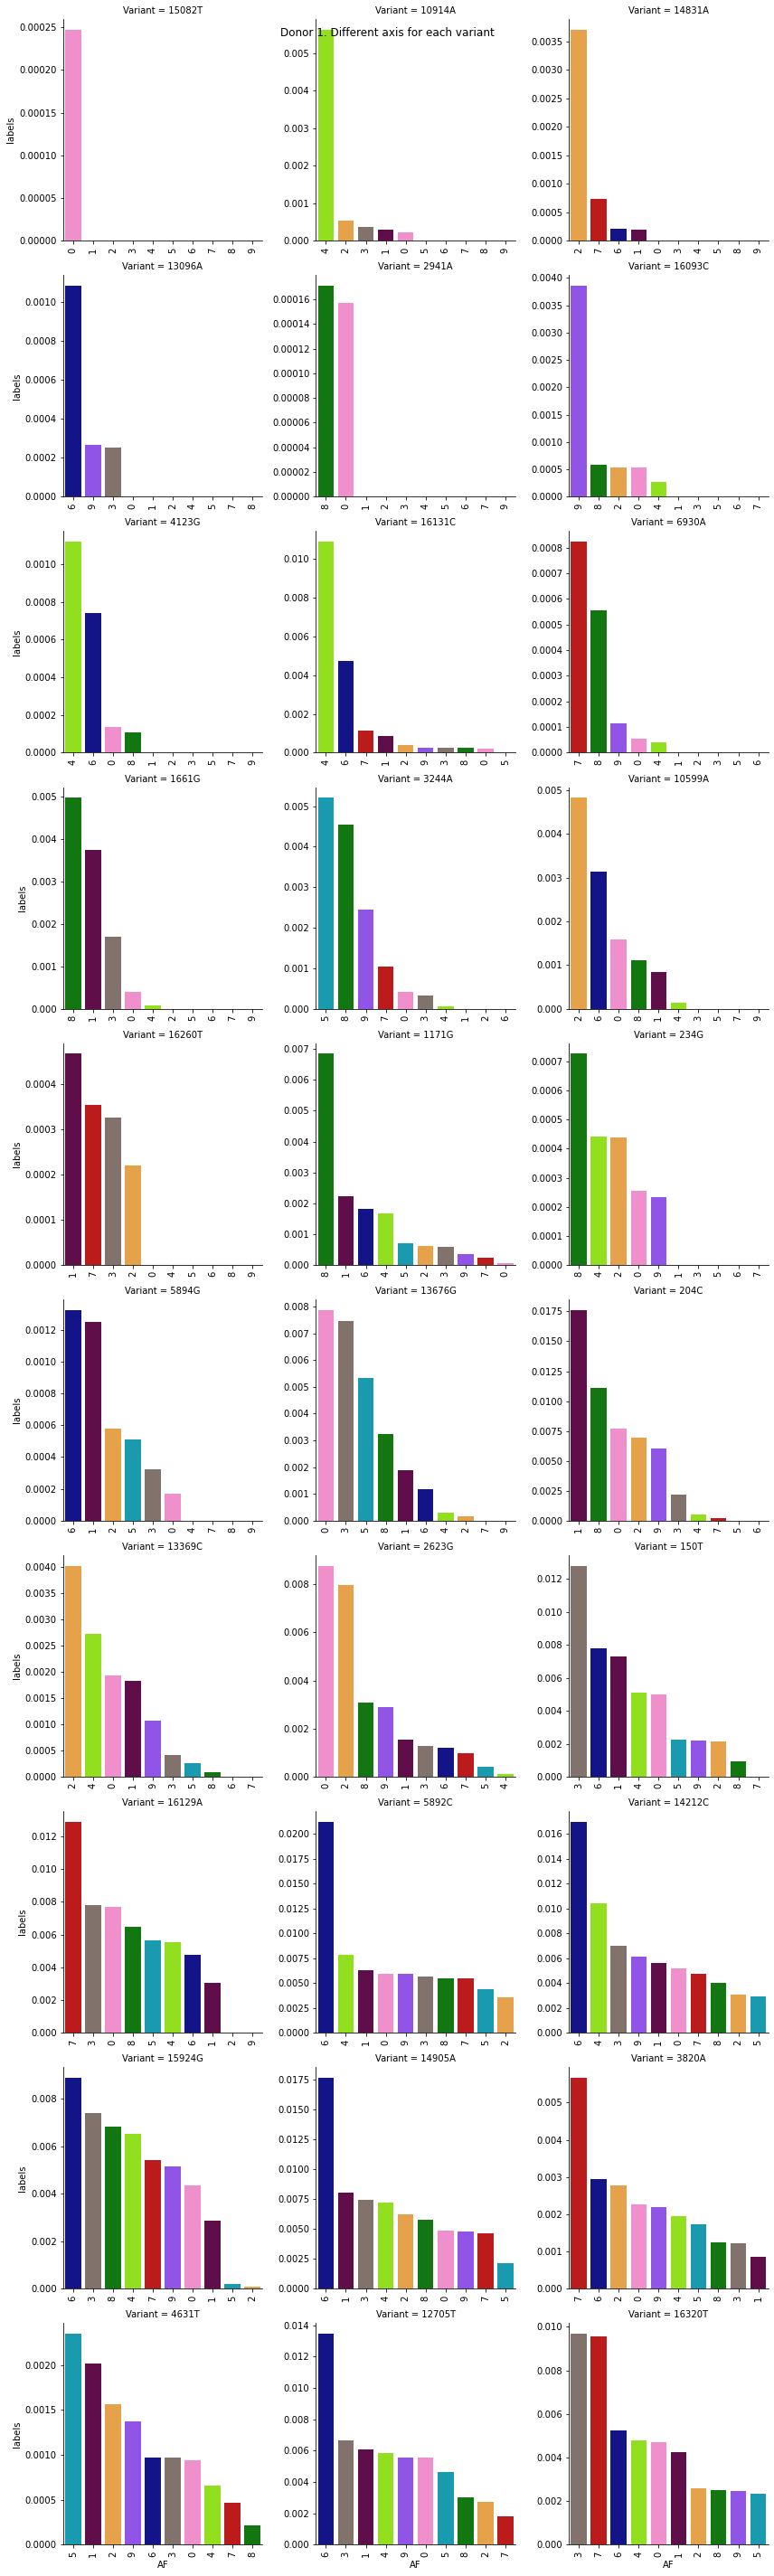

In [31]:
def get_cv(x):
    return np.std(x, ddof=1)/ np.mean(x) * 100


def order_bar(af, labels, **kwargs):
    df = pd.DataFrame({"AF":af, "clust": labels}) #, columns=['AF',"clust"])
    order = labels.loc[af.sort_values(ascending=False).index] #by="AF", ascending=False)["labels"]
    #print(df)
    #sns.barplot(data=df, y="AF", x="clust", order=order, hue="clust", hue_order=hue_order)
    sns.barplot(y=af, x=labels, order=order, hue=labels, palette=color_out[2],dodge=False)#, hue_order=hue_order)
    #plt.xticks(rotation=45)
    return


for curr_don, don_lin_mt_af in lin_mt_af.reset_index().groupby("donor"):
    curr_don_mt = don_lin_mt_af.set_index(["labels","donor"])
    lin_mt_cv = curr_don_mt.apply(get_cv, axis=0).sort_values(ascending=False)
    curr_don_mt = curr_don_mt.loc[:,lin_mt_cv.index]

    lin_mt_af_w = curr_don_mt.iloc[:,:n_vars].reset_index().melt(id_vars=["labels", "donor"], var_name="Variant", value_name="AF")
    #print(lin_mt_af_w)
    lin_mt_af_w["donor"] = lin_mt_af_w["donor"].astype(str)
    lin_mt_af_w["labels"] = lin_mt_af_w["labels"].astype(str)
    hue_order = lin_mt_af_w["labels"].unique()
    color_out = create_color_df_v02(lin_mt_af_w, col="labels", clr_type='categorical')

    g = sns.catplot(x="labels", y="AF", col="Variant", kind='bar', data=lin_mt_af_w, col_wrap=4, 
                    hue_order=hue_order, palette=color_out[2])
    g.set_xticklabels(rotation=30)
    g.fig.suptitle(f"Donor {curr_don}")
    
    
#    g = sns.catplot(x="labels", y="AF", col="Variant", kind='bar', data=don_af, col_wrap=4, 
 #               sharey=False, sharex=False, hue=None)
    g = sns.FacetGrid(col="Variant", data=lin_mt_af_w, col_wrap=3, sharex=False, sharey=False, 
                      hue_order=hue_order,height=4)
    g.map(order_bar, "AF", "labels")
    g.set_xticklabels(rotation=90)
    g.fig.suptitle(f"Donor {curr_don}. Different axis for each variant")
    g.fig.tight_layout()